In [2]:
import rasterio
import numpy as np
# Open our raster dataset
dataset = rasterio.open('nc_2010_ccap_land_cover_20140604.img')
image = dataset.read()

In [3]:
# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 1

Image size is: 13481 rows x 18639 columns

Raster driver: HFA

Image projection:
+ellps=GRS80 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +towgs84=0,0,0,0,0,0,0 +units=m +x_0=0 +y_0=0


In [4]:
gt = dataset.transform
print(gt)

| 30.00, 0.00, 1293045.00|
| 0.00,-30.00, 1727745.00|
| 0.00, 0.00, 1.00|


In [5]:
pixelSizeX = gt[0]
pixelSizeY =-gt[4]

print(pixelSizeX)
print(pixelSizeY)

30.0
30.0


In [6]:
image.shape

(1, 13481, 18639)

In [7]:
np.max(image)

22

In [8]:
np.min(image)

0

In [9]:
import matplotlib.pyplot as plt
# use the matplotlib.pyplot function "imshow" for an image -- nir at first
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(image[0,:,:])

In [10]:
image[0,0,0]

0

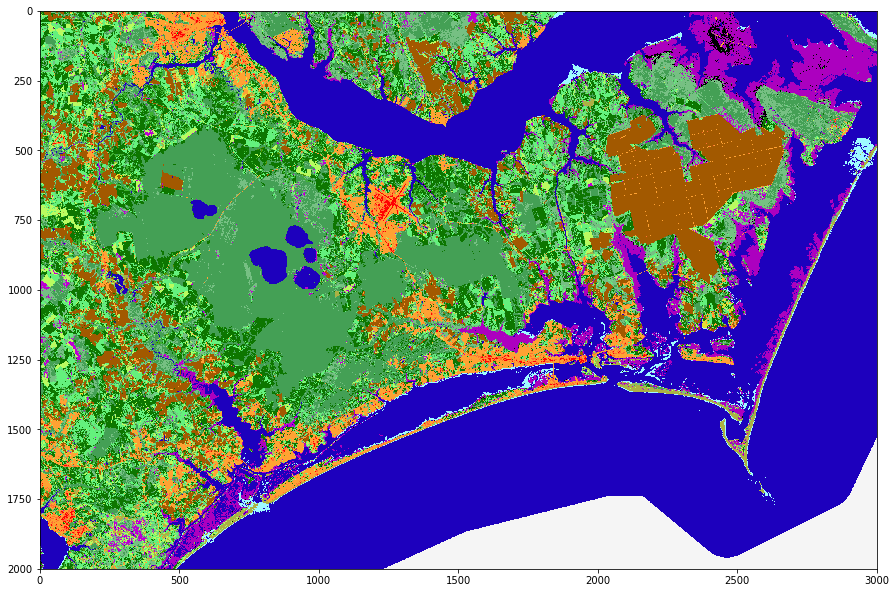

In [13]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (29, 0, 189)), # Palustrine Aquatic Bed
(23, (91, 199, 169)), # Estuarine Aquatic Bed
(24, (159, 251, 255)), # Tundra
(25, (159, 251, 255)), # Snow/Ice
))

n = int(np.max(image))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(15,15))

axs.imshow(image[0,7250:9250, 13000:16000], cmap=cmap, interpolation='none')
#axs.imshow(image[0,:, :], cmap=cmap, interpolation='none')

plt.show()

In [12]:
flat_img = image.flatten()

In [14]:
! ls

allpico-dataexport_crt.txt  hurricanes.ipynb
florence_track.txt	    landcover_mapping.ipynb
gee_utils.ipynb		    nc_2010_ccap_land_cover_20140604.img
hurricane_costs.csv	    storms.csv
hurricanes.csv
